#### Helper Code

This code runs out of the box on Google Colab. It is also the recommended way to run this notebook if you do not already have an environment with Python 3 and TensorFlow already set up.

In [0]:
import numpy as np
import os

matplotlib_style = "ggplot"
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')

from IPython.core.pylabtools import figsize
notebook_screen_res = "retina"
%config InlineBackend.figure_format = notebook_screen_res

from IPython.display import clear_output

In [2]:
import tensorflow as tf
try:
    tf.enable_eager_execution()
    print("Enabled eager execution")
except Exception as e:
    print(e)
    print("Eager execution:", tf.executing_eagerly() )
    

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print("TensorFlow\t\t", ":", tf.__version__)
print("TensorFlow Probability\t", ":", tfp.__version__)

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
print("Devices:")
print([x.name for x in local_device_protos])

Enabled eager execution

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

TensorFlow		 : 1.13.1
TensorFlow Probability	 : 0.6.0
Devices:
['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


In [0]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    return tf.contrib.framework.nest.pack_sequence_as(tensors,
                                                      [t.numpy() if tf.contrib.framework.is_tensor(t) else t
                                                       for t in tf.contrib.framework.nest.flatten(tensors)])

In [0]:
from sklearn.metrics import mean_squared_error

# 05. CLT & Approximations in Distributions

## Central Limit Theorem


Let ${X_1 .. X_n}$ be a **random sample**, such that each $X_i$ has mean $\mu$ and variance $\sigma^2$ , and $\bar{X_n}$ be its sample mean.

As $n$ becomes sufficiently large, a **normal distribution** with the same mean $\mu$ and same variance $\frac{\sigma^2}{n}$ is a **good approximation** to the **distribution of the sample mean** $\bar{X_n}$ .

The CLT does not tell us anything new about the distribution of $X_i$ .


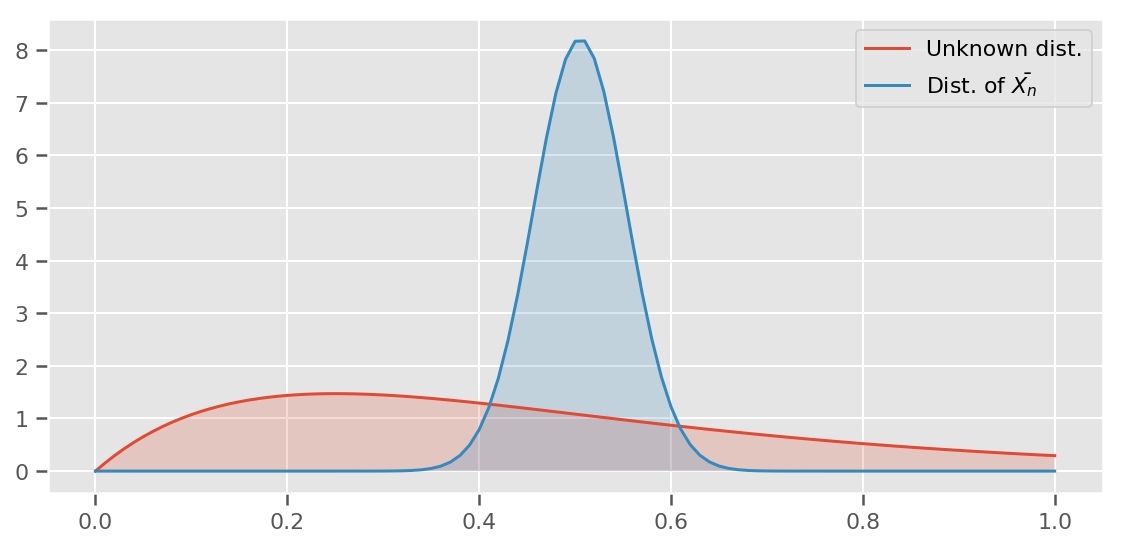

In [5]:
#@title Central Limit Theorem { run: "auto" }

sample_size = 50 #@param {type:"slider", min:1, max:200, step:1}
num_of_samples = 50

alpha, beta = 2, 4
dist = tfd.Gamma(alpha, beta)

n = 101
space = tf.linspace(start=0., stop=1.0, num=n, name="linspace")
dist_values = dist.prob(space)

dist_samples = []
for i in range(num_of_samples):
    dist_samples.append(np.mean(dist.sample(sample_size).numpy()))
dist_samples = np.asarray(dist_samples)

var = np.power(np.var(dist_samples), 0.5).astype("float32")
mean = np.mean(dist_samples)

sample_dist = tfd.Normal(loc=mean, scale=var)
sample_dist_values = sample_dist.prob(space)

plt.figure(figsize(8, 4))

plt.plot(space,
         dist_values,
         label="Unknown dist.")
plt.fill_between(space, 0, dist_values, alpha=0.2)

plt.plot(space,
         sample_dist_values,
         label=r"Dist. of $\bar{X_n}$")
plt.fill_between(space, 0, sample_dist_values, alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

## Approximation of distributions

### Approximation of binomial distribution as normal distribution

Suppose $0 < p < 1$ , and let $X_1 , X_2 , X_3 , . . .$ be an inﬁnite sequence of independent Bernoulli RV, each with parameter $p$.

For each integer $n$, let $Y_n$ be the sum $Y_n = X_1 + · · · + X_n$ .

> $Y_n$ is a binomial RV with parameters $n$ and $p$
> 
> **E**[$Y_n$] = $np$ ; var($Y_n$) = $np(1 − p)$

**By Central Limit Theorem:**

If $n$ is large, then $Y_n$ is approximately a normal RV with the same mean $np$ and same variance $np(1 − p)$.

In other words, the normal distribution is a good approximation to the binomial distribution if $n$ is large.

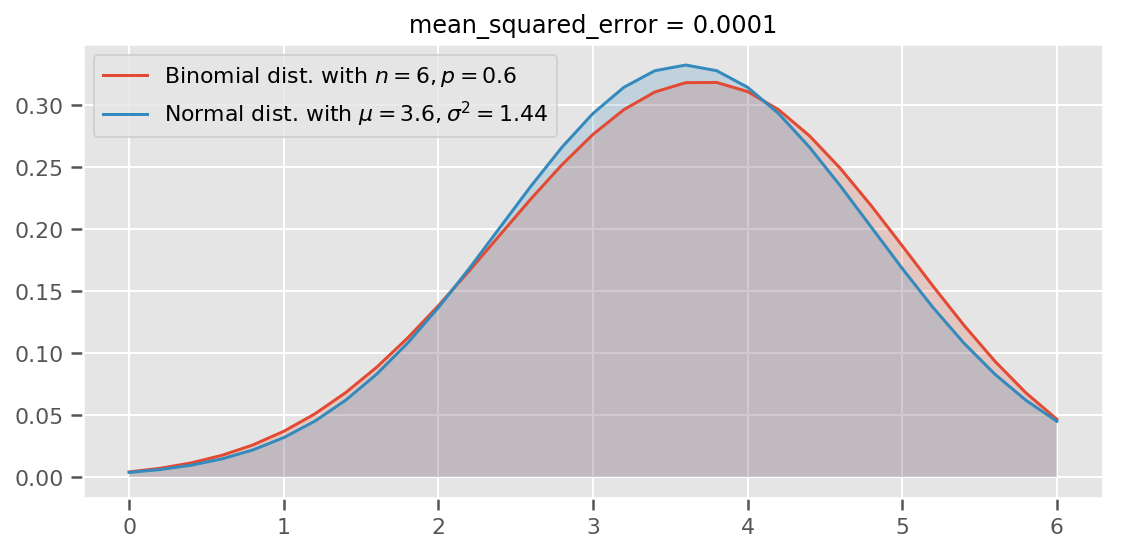

In [6]:
#@title Approximiating Binomial with Normal  { run: "auto" }
n = 6 #@param {type:"slider", min:1, max:40, step:1}
p = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}

res = 31

binomial = tfd.Binomial(total_count=n, probs=p)
space = tf.linspace(start=0., stop=n, num=res, name="linspace")

binomial_values = binomial.prob(space[:, tf.newaxis])
binomial_values = binomial_values.numpy().reshape((res))

mean = n*p
var = n*p*(1-p)
std_div = var**0.5

normal = tfd.Normal(loc=mean, scale=std_div)
normal_values = normal.prob(space)

binomial_label = r"Binomial dist. with $n="+str(n)+",p="+str(p)+"$"
normal_label = r"Normal dist. with $\mu="+str(round(mean,2))+",\sigma^2="+str(round(var,2))+"$"

mse = mean_squared_error(normal_values, binomial_values)
mse = '{:g}'.format(float('{:.1g}'.format(mse)))

plt.figure(figsize(8, 4))

plt.plot(space,
         binomial_values,
         label=binomial_label)
plt.fill_between(space, 0, binomial_values, alpha=0.2)

plt.plot(space,
         normal_values,
         label=normal_label)
plt.fill_between(space, 0, normal_values, alpha=0.2)

plt.title("mean_squared_error = "+str(mse))

plt.legend()
plt.tight_layout()
plt.show()

### Approximating Binomial with Poisson

**Theorem**

Let $X$ be a binomial RV with parameters $n$ and $p$. Suppose we let $n\rightarrow\infty$ and $p\rightarrow0$ in such a way that $np\rightarrowλ$ for some value $\lambda>0$. 

Then the pmf of $X$ approaches the pmf of the Poisson RV with parameter $\lambda$, i.e. p($x; n, p$)$\rightarrow$p($x; \lambda$).

**Corollary**

For any binomial distribution in which $n$ is large and $p$ is small, p($x; n, p$) ≈ p($x; \lambda$), where $\lambda = np$.

**Rule of Thumb**

Poisson distribution is a good approximation to binomial distribution if $n>50$ and $np<5$.

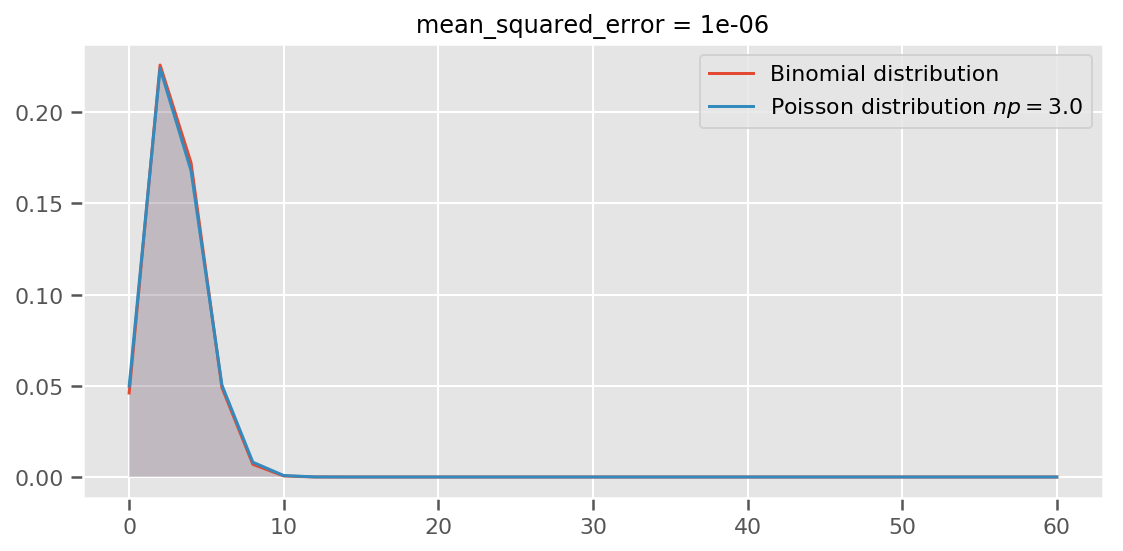

In [7]:
#@title Closeness of Poisson(λ=np) to Binomial(n,p)  { run: "auto" }
n = 60 #@param {type:"slider", min:1, max:120, step:1}
p = 0.05 #@param {type:"slider", min:0, max:1, step:0.05}

space = tf.linspace(start=0., stop=n, num=n//2+1, name="linspace")

# Binomial distribution

binomial = tfd.Binomial(total_count=n, probs=p)
binomial_values = binomial.prob(space[:, tf.newaxis])
binomial_values = binomial_values.numpy().reshape((n//2+1))

plt.figure(figsize(8, 4))
plt.plot(space,
         binomial_values,
         label="Binomial distribution")
plt.fill_between(space, 0, binomial_values, alpha=0.2)

# Poisson distribution

poisson = tfd.Poisson(rate=n*p)
poisson_values = poisson.prob(space[:, tf.newaxis])
poisson_values = poisson_values.numpy().reshape((n//2+1))

mse = mean_squared_error(poisson_values, binomial_values)
mse = '{:g}'.format(float('{:.1g}'.format(mse)))

plt.title("mean_squared_error = "+str(mse))

plt.plot(space,
         poisson_values,
         label=r"Poisson distribution $np="+str(round(n*p,1))+r"$")
plt.fill_between(space, 0, poisson_values, alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

### Approximating Poisson with Normal

If $\lambda$ is suﬃciently large, then the Poisson distribution with parameter $\lambda$ is approximately the normal distribution with mean $\lambda$ and variance $\lambda$.

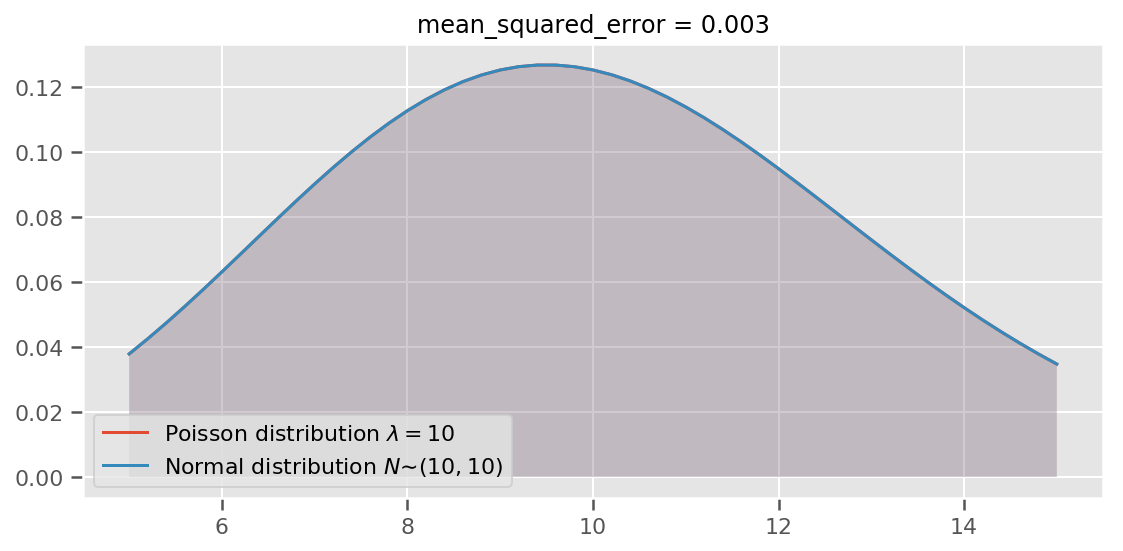

In [8]:
#@title Closeness of Poisson(λ) to N~(λ,λ)  { run: "auto" }
𝜆 = 10 #@param {type:"slider", min:1, max:100, step:1}

n = 51

if 𝜆<10:
    space = tf.linspace(start=𝜆*0.5, stop=𝜆*1.5, num=n, name="linspace")

else:
    space = tf.linspace(start=𝜆*0.5, stop=𝜆*1.5, num=n, name="linspace")

# Normal distribution

normal = tfd.Normal(loc=𝜆, scale=𝜆)
normal_values = normal.prob(space)
normal_values = normal_values.numpy().reshape((n))

# Poisson distribution

poisson = tfd.Poisson(rate=𝜆)
poisson_values = poisson.prob(space[:, tf.newaxis])
poisson_values = poisson_values.numpy().reshape((n))

mse = mean_squared_error(normal_values, poisson_values)
mse = '{:g}'.format(float('{:.1g}'.format(mse)))

plt.title("mean_squared_error = "+str(mse))

plt.plot(space,
         poisson_values,
         label=r"Poisson distribution $\lambda="+str(𝜆)+r"$")
plt.fill_between(space, 0, poisson_values, alpha=0.2)

plt.plot(space,
         poisson_values,
         label=r"Normal distribution $N∼("+str(𝜆)+r","+str(𝜆)+r")$")
plt.fill_between(space, 0, poisson_values, alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

## References

1. Lecture 12, Introduction to Probability and Statistics, 50.034 (2018), Singapore University of Technology and Design

